# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Random Forest, and will then apply a Decision Tree classsifier and random forest on the MNIST hand written digits dataset that we already saw.


## Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


#### Answer


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
from math import log2

#### ID3 related functions (Entropy and gain calculations)

In [3]:
def calc_entropy(y):
    ''' Calculate entropy for a vector of class labels'''
    
    entropy = 0
    data_size = y.shape[0]
    unique_values, unique_values_counts = np.unique(y, return_counts=True)
    
    for idx, _ in enumerate(unique_values):
        probability = unique_values_counts[idx] / data_size
        if probability != 0:
            entropy += - probability * log2(probability)

    return entropy


def calc_information_gain_of_feature(X ,y, feature):
    ''' Calculate information gain for a feature'''
    
    entropy_dataset = calc_entropy(y) # Entropy of dataset
    data_size = X.shape[0]
    
    unique_values_of_feature, unique_values_counts = np.unique(X[:, feature], return_counts=True)
    gain = entropy_dataset
    
    for idx, value in enumerate(unique_values_of_feature):
        probability = unique_values_counts[idx] / data_size
        indices_for_value = np.where(X[:,feature] == value)
        entropy = calc_entropy(y[indices_for_value])
        gain -= probability * entropy
            
    return gain


def find_best_feature(X, y, features, argmax = True):
    ''' find the feature with highest information gain. Argmax is passed to change selection in case 
        of a tie in gains'''
    
    gains = []
    for feature in features:
        gain = calc_information_gain_of_feature (X, y, feature)
        gains.append(gain)

    if argmax:
        highest_gain_feature = np.argmax(np.array(gains))
    else: # in case of tie in highest gain - choose the last one
        highest_gain = max(np.array(gains))
        highest_indices = np.where(np.array(gains) == highest_gain)
        highest_gain_feature = np.array(highest_indices[0][-1])
    
    feature_with_highest_gain = features[highest_gain_feature]
    
    return feature_with_highest_gain

#### Tree class

In [4]:
class Node:

    def __init__(self, parent = None, label = None, is_leaf = False, feature = None):
        self.label = label       # target label
        self.parent = parent     # parent node
        self.feature = feature   # feature index (for desicion nodes)
        self.is_leaf = is_leaf   # is leaf or decision node
        self.children = {}       # dictionary: key is feature value, value is child node        
    
    def add_child(self, child, value):
        self.children[value] = child
        child.set_parent(self)
        
    def print_children(self):
        print('children of node ', self.feature, ': ' )
        for k,v in self.children.items():
            print(f'value = {k}')
            v.print_node()
        
    def set_feature(self, data):
        self.feature = data        

    def set_label(self, label):
        self.label = label
        
    def set_parent(self, parent):
        self.parent = parent

    def print_node(self, indent = 0):
        ''' print node (label or feature) '''
    
        if self.is_leaf:
            print(" " * indent + 'leaf, label = ', self.label)
        else:
            print(" " * indent + 'desicion node, feature = ', self.feature)
            
            
    def print_tree(self, indent = 0):
        ''' recursive function that prints the tree'''
        
        node = self
        if node.is_leaf:
            node.print_node(indent)
        else: # desicion node
            print(" " * indent + 'desicion node, feature = ',self.feature)
            for k,v in self.children.items():
                print(" " * (indent + 8) + 'feature value ',k)
                v.print_tree(indent + 8)

                   
 

#### ID3 helper functions

In [5]:
def get_most_common_label_in_dataset(node):
    ''' return the root node's label, which has the most common label in the dataset '''
    
    node_it = node
    while node_it != None:
        node_it = node_it.parent
    return node_it.label


def get_most_common_label_in_set(y):
    
    unique_values, unique_values_counts = np.unique(y, return_counts=True)
    return unique_values[ np.argmax(unique_values_counts)]
 

    
def ID3_build_tree(X, y, features = None, tree_level = 0, max_depth = 10, parent_node = None, argmax = True):

    if features is None:
        features = np.arange(X.shape[1])
        
    if tree_level >= max_depth:
        return Node(parent_node, get_most_common_label_in_set(y), is_leaf = True)


    if len(features) == 0:
        return  Node(parent_node, parent_node.label, is_leaf = True)     

    #If there are no examples left, it means that no example has been observed for this combination of attribute
    # values, and we return a default value calculated from the plurality classification of the entire datset.
    if X.shape[0] == 0:
        most_common_in_dataset  = get_most_common_label_in_dataset(parent_node)
        return Node(parent = parent_node, label = most_common_in_dataset, is_leaf = True) 

    if np.unique(y).size == 1:   # pure data, all with the same label
        return Node (parent = parent_node, label = y[0].item(), is_leaf = True)    


    best_feature = find_best_feature(X, y, features, argmax)
    node = Node(feature = best_feature, label = get_most_common_label_in_set(y))

    # split the data by values of best feature and call this recursively  
    unique_values_of_best_feature = np.unique(X[:, best_feature])
    
    # exclude best feature
    features = np.delete(features, np.argwhere(features == best_feature)) if len(features) > 1 else []

    for value in unique_values_of_best_feature:

        # find indicies for every unique value (for the split)
        indices_for_feature_value = np.where(X[:,best_feature] == value) 
        
        # split based on best feature and continue recursively 
        subtree = ( ID3_build_tree (X[indices_for_feature_value], 
                         y[indices_for_feature_value],
                         features,
                         tree_level = tree_level + 1,
                         parent_node = node,
                         max_depth = max_depth,
                         argmax = argmax))
    
        node.add_child(subtree, value)

    return node


#### ID3 class

In [6]:
class ID3:

    def __init__(self, max_depth = 10):
        self.max_depth = max_depth
        self.tree = None
        
    def fit(self, X, y, argmax = True):
        self.tree = ID3_build_tree(X, y, max_depth = self.max_depth, argmax = argmax)                
    
    def predict(self, X_pred):
        node = self.tree
        X_pred = np.array(X_pred)
        y_pred = []
        for row in range(X_pred.shape[0]):
            pred = self.predict_point(X_pred[row])
            y_pred.append(pred)
            
        return y_pred
        
    def predict_point(self, data_point):
        node = self.tree
        
        while node.is_leaf == False:  # keep going as long as we didn't reach a leaf
            data_value_for_feature = data_point[node.feature]
            if data_value_for_feature in list(node.children.keys()):
                index = list(node.children.keys()).index(data_value_for_feature)
                node = list(node.children.values())[index]
            else:
                return node.label
    
        return node.label
    
        
    def print_tree(self):
        self.tree.print_tree()



#### Show that training error of the resulting decision tree is at least 1/4.

In [7]:
import sklearn.metrics as sm

def predict_and_report_error(tree, X, y, print_output = True):
    
    y_pred = tree.predict(X)
    error_rate = 1 - sm.accuracy_score(y, y_pred)
    
    if print_output:
        print('y train     ', y.T)
        print('y train pred', y_pred)
        print(f'error rate = {error_rate}')
        
    return error_rate


In [8]:
# Q1 dataset

X_q1 = np.array(
    [(1,1,1),
     (1,0,0),
     (1,1,0),
     (0,0,1)])
y_q1 = np.array([[1],
              [1],
              [0],
              [0]])
print( X_q1, '\n', y_q1) 

[[1 1 1]
 [1 0 0]
 [1 1 0]
 [0 0 1]] 
 [[1]
 [1]
 [0]
 [0]]


In [9]:
# let's use the id3 tree in depth 2 and check the error

decision_tree_id3 = ID3(max_depth = 2)
decision_tree_id3.fit(X_q1, y_q1)
decision_tree_id3.print_tree()

predict_and_report_error(decision_tree_id3, X_q1, y_q1)

desicion node, feature =  0
        feature value  0
        leaf, label =  0
        feature value  1
        desicion node, feature =  1
                feature value  0
                leaf, label =  1
                feature value  1
                leaf, label =  0
y train      [[1 1 0 0]]
y train pred [0, 1, 0, 0]
error rate = 0.25


0.25

#### error is 0.25

We can change the way the tree picks the highest gain when gets two equal gains.
Currnt tree uses argmax that picks the first one. Even when we pick the other feature - training error is still 0.25



In [10]:
# let's pick the other feature

decision_tree_id3 = ID3(max_depth = 2)
decision_tree_id3.fit(X_q1, y_q1, argmax = False)
decision_tree_id3.print_tree()

predict_and_report_error(decision_tree_id3, X_q1, y_q1)

desicion node, feature =  0
        feature value  0
        leaf, label =  0
        feature value  1
        desicion node, feature =  2
                feature value  0
                leaf, label =  0
                feature value  1
                leaf, label =  1
y train      [[1 1 0 0]]
y train pred [1, 0, 0, 0]
error rate = 0.25


0.25

Error is still 0.25. This is happening becuase in this dataset, feature 0 will always have the highest gain,
so feature 0 will be the first one in the tree, and then since the other two have equal high entropy (the features values are split evenly between 0's and 1's and the labes are split between 0 and 1, which gives entory of 1 : $ 0.5*1+0.5*1=1 $, a tree in depth of 2 will not be enough for zero training error.

#### Find a decision tree of depth 2, which attains zero training error.

For this, we need a different tree, that has a different order of features. Let's randomize the features selection and search for a tree that returns zero training error.


In [11]:
# similar to id3, just picks features randomly

def build_tree(X, y, features = None, tree_level = 0, max_depth = 10, parent_node = None):

    if features is None:
        features = np.arange(X.shape[1])
        
    if tree_level >= max_depth:
        label = get_most_common_label_in_set(y)
        return Node(parent_node, label, is_leaf = True)

    if len(features) == 0:
        return  Node(parent_node, parent_node.label, is_leaf = True)     

    #If there are no examples left, it means that no example has been observed for this combination of attribute
    # values, and we return a default value calculated from the plurality classification of the entire dataset
    if X.shape[0] == 0:
        most_common_in_dataset  = get_most_common_label_in_dataset(parent_node)
        return Node(parent = parent_node, label = most_common_in_dataset, is_leaf = True) 

    if np.unique(y).size == 1:   # pure data, all with the same label
        return Node (parent = parent_node, label = y[0].item(), is_leaf = True)    

    selected_feature = np.random.choice(features,1).item()
    node = Node(feature = selected_feature, label = get_most_common_label_in_set(y))

    # split the data by values of best feature and call this recursively  
    unique_values_of_best_feature = np.unique(X[:, selected_feature])
    
    # exclude best feature
    features = np.delete(features, np.argwhere(features == selected_feature)) if len(features) > 1 else []

    for value in unique_values_of_best_feature:
        # find indicies for every unique value (for the split)
        indices_for_feature_value = np.where(X[:,selected_feature] == value) 
        
        # split based on best feature and continue recursively 
        subtree = ( ID3_build_tree (X[indices_for_feature_value], 
                         y[indices_for_feature_value],
                         features,
                         tree_level = tree_level + 1,
                         parent_node = node,
                         max_depth = max_depth))
    
        node.add_child(subtree, value)

    return node


In [12]:
# general desicion tree classifier that randomizes features selection

class Decision_Tree_Classifer:

    def __init__(self, max_depth = 10):
        self.max_depth = max_depth
        self.tree = None
        
    def fit(self, X, y):
        self.tree = build_tree(X, y, max_depth = self.max_depth)                
        
    def print_tree(self):
        self.tree.print_tree()
    
    def predict(self, X_pred):
        node = self.tree
        X_pred = np.array(X_pred)
        y_pred = []
        for row in range(X_pred.shape[0]):
            pred = self.predict_point(X_pred[row])
            y_pred.append(pred)
            
        return y_pred
        
    
    def predict_point(self, data_point):
        node = self.tree
        
        while node.is_leaf == False:  # keep going as long as we didn't reach a leaf
            data_value_for_feature = data_point[node.feature]
            if data_value_for_feature in list(node.children.keys()):
                index = list(node.children.keys()).index(data_value_for_feature)
                node = list(node.children.values())[index]
            else:
                return node.label
    
        return node.label
        

Let's use this tree and search for a tree that returns 0 training error

In [13]:
error_rate = 1

while error_rate > 0:

    # generating desicion tree with random feature selection
    random_tree = Decision_Tree_Classifer( max_depth = 2)
    random_tree.fit(X_q1, y_q1)
    
    error_rate = predict_and_report_error(random_tree, X_q1, y_q1, print_output = False)
    if error_rate == 0:
        print('Tree with 0 training error:')
        print('===========================')
        random_tree.print_tree()
        predict_and_report_error(random_tree, X_q1, y_q1, print_output = True)
    

Tree with 0 training error:
desicion node, feature =  2
        feature value  0
        desicion node, feature =  1
                feature value  0
                leaf, label =  1
                feature value  1
                leaf, label =  0
        feature value  1
        desicion node, feature =  0
                feature value  0
                leaf, label =  0
                feature value  1
                leaf, label =  1
y train      [[1 1 0 0]]
y train pred [1, 1, 0, 0]
error rate = 0.0


## Implementing Random Forest From Scratch
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes). 

* Compelete the skeleton class below (hint: you should also create a `DecisionTree` class that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(n)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
  



It then goes through the list of all features and their values to find a binary split that gives us the maximum improvement in MSE. This is typically calculated by predicting the mean of each of the two new subsets and computing their respective MSEs weighted by the number of observations in each.

For regression problems the inventors recommend p/3 (rounded down) features with a minimum node size of 5 as the default.[3]:592 In practice the best values for these parameters will depend on the problem, and they should be treated as tuning parameters.

In [14]:
EPSILON = 1e-10

In [15]:
# implement tree for regression classifier

class Node:

    def __init__(self, parent=None, avg_target=None, feature=None, samples=None, mse=0, split_value = None, is_leaf = False):
        self.avg_target = avg_target  # target value (average of all samples in this node)
        self.samples = samples        # number of samples in node
        self.mse = mse  
        self.parent = parent 
        self.feature = feature        # feature index (for decision nodes)
        self.left = None
        self.right = None
        self.is_leaf = is_leaf
        self.split_value = split_value  # split valur of self.feature

    def set_left(self, node):
        self.left = node

    def set_right(self, node):
        self.right = node

In [16]:
def calculate_mse(prediction, y_true):
    y_pred = np.ones(len(y_true)) * prediction  # make the same prediction to all observations
    return np.mean((y_true - y_pred) ** 2)

In [17]:
# Decision regression tree for Random Forest

class DecisionTree:

    def __init__(self, x, y, max_features, min_leaf):
        self.tree = self.build_tree(x, y, max_features, min_leaf)

    def predict(self, x_pred):
        node = self.tree
        y_pred = []
        for row in range(X_pred.shape[0]):
            prediction = self.predict_point(X_pred[row])
            y_pred.append(prediction)

        return y_pred


    def predict_point(self, data_point):
        node = self.tree  # root

        while not node.is_leaf:  # keep going as long as we didn't reach a leaf
            if data_point[node.feature] < node.split_value:
                    node = node.left
            else: # value is larger than split value
                    node = node.right
                
        return node.avg_target

    
    def build_tree(self, X, y, max_features=10, min_leaf=1, parent_node=None, features = None):

        if features is None:
            features = np.arange(X.shape[1])

        # if all target variables are the same or if we don't have enough rows to split - make a leaf node:
        if np.std(y) < EPSILON or len(y) < 2 * min_leaf:
            mse = calculate_mse(np.mean(y), y)
            return Node(parent = parent_node, avg_target = y[0].item(), samples=X.shape[0], mse = mse, is_leaf = True)

        # if we got here - we have enough data points to split, select the best feature and split point
        randomly_selected_features = np.random.choice(features, max_features, replace=False)
        best_feature, feature_threshold, mse = self.find_best_feature_and_split(X, y, randomly_selected_features, min_leaf)

        # we couldn't find a split point that wouldn't break the min_leaf restriction - don't split and return leaf
        if feature_threshold is None:
            mse = calculate_mse(np.mean(y), y)
            return Node(parent = parent_node, avg_target = np.mean(y), samples=X.shape[0], mse = mse, is_leaf = True)

        node = Node(feature=best_feature, samples=X.shape[0], avg_target=np.mean(y), mse=mse, split_value = feature_threshold)

        indices_small = np.where(X[:, best_feature] < feature_threshold)
        indices_large = np.where(X[:, best_feature] >= feature_threshold)

        # if the number of indiciess in either group < min _leaf we don't split. make the node a leaf and return
        if indices_small[0].size < min_leaf or indices_large[0].size < min_leaf:
            node.is_leaf = True
            return node

        # split based on best feature and continue recursively
        left_node = (self.build_tree(X[indices_small], y[indices_small], parent_node=node, min_leaf=min_leaf,
                                     max_features = max_features, features = features))

        node.set_left(left_node)

        # larger then threshold
        right_node = (self.build_tree(X[indices_large], y[indices_large], parent_node=node, min_leaf=min_leaf,
                                      max_features = max_features, features = features))
        node.set_right(right_node)

        return node


    def find_best_feature_and_split(self, x, y, features, min_leaf):
        ''' find the feature and split with lowest variance '''

        min_var = np.inf
        best_feature = -1
        split_value = None

        for feature in features:
            split, score =  self.find_split_point_for_feature(x, y, feature, min_leaf)
            if score < min_var:
                min_var = score
                best_feature = feature
                split_value = split

        return best_feature, split_value, min_var

    
    def find_split_point_for_feature(self, x, y, feature_index, min_leaf):

        total_values = len(y)
        feature_values_vector = x[:, feature_index]
        sorted_feature_indices = np.argsort(feature_values_vector)

        sorted_feature_values = feature_values_vector.copy()[sorted_feature_indices]
        sorted_target_values = y.copy()[sorted_feature_indices]

        # initial index is min_leaf
        first_split_index = min_leaf
        first_split_value = feature_values_vector[first_split_index]

        small_sum = np.sum(sorted_target_values[:first_split_index])
        small_sum_squares = np.sum(sorted_target_values[:first_split_index] ** 2)

        large_sum = np.sum(sorted_target_values[first_split_index:])
        large_sum_squares = np.sum(sorted_target_values[first_split_index:] ** 2)

        size_small = min_leaf
        size_large = total_values - size_small
        
        var_small = (small_sum_squares / size_small - (small_sum / size_small) ** 2)
        var_large = (large_sum_squares / size_large - (large_sum / size_large) ** 2)

        weighted_var_score_for_idx = var_small * size_small + var_large * size_large

        best_score = weighted_var_score_for_idx
        best_split_value = first_split_value

        for idx in range(first_split_index + 1, total_values - min_leaf + 1):
            small_sum += sorted_target_values[idx - 1].item()
            small_sum_squares += sorted_target_values[idx - 1].item() ** 2

            large_sum -= sorted_target_values[idx - 1].item()
            large_sum_squares -= sorted_target_values[idx - 1].item() ** 2

            size_small = idx
            size_large = total_values - size_small

            var_small = (small_sum_squares / size_small - (small_sum / size_small) ** 2)
            var_large = (large_sum_squares / size_large - (large_sum / size_large) ** 2)

            weighted_var_score_for_idx = var_small * size_small + var_large * size_large

            if weighted_var_score_for_idx < best_score:
                best_score = weighted_var_score_for_idx
                best_split_value = sorted_feature_values[idx]

        return best_split_value, best_score


In [18]:
# class for Random Forest Classifier

class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, min_leaf,max_features = None):
        self.X = X
        self.y = y
        self.n_trees = n_trees 
        self.forest = []
        self.indices = []
        self.min_leaf = min_leaf
        self.sample_sz = sample_sz
        self.max_features = max_features

        # if wasn't initialized by user - initialize max feature to be sqrt of number of features
        if max_features is None:
            self.max_features = int(np.ceil(np.sqrt(X.shape[1])))
            
        # create n_trees, sample sample_sz rows for each tree
        for i in range(n_trees):
            
            sampled_indices = np.random.choice(np.arange(self.X.shape[0]),
                                               size=sample_sz,
                                               replace=True)
            X_sample = X[sampled_indices]
            y_sample = y[sampled_indices]
            self.indices.append(sampled_indices)

            tree_regressor = DecisionTree(X_sample, y_sample, min_leaf = min_leaf, max_features = self.max_features)
            
            self.forest.append(tree_regressor)  # Add tree regressor to the forest

            
    def predict_point(self, x_pred_point):
        
        predictions_vec = []

        # go over all trees and get their prediction. Return the average prediction from all trees
        for tree_idx in range(self.n_trees):
            prediction = self.forest[tree_idx].predict_point(x_pred_point) 
            predictions_vec.append(prediction)

        return np.mean(predictions_vec)
       
            
    def predict(self, x):
        ''' use mean of the target values in the leaf node matching each row of the given X.
        The result is a vector of predictions matching the number of rows in X '''

        y_pred = []
        
        for point in range(x.shape[0]):
            y_pred.append(self.predict_point(x[point]))
            
        return y_pred

    
    def oob_mse(self):
        ''' compute the mean squared error over all out of bag (oob) samples: for each sample
            calculate the squared error using predictions from the trees that do not contain x in their
            respective bootstrap sample'''

        index_of_oob = []  # mark the OOB datapoints that we can test (there was a tree that didn't use them)
        trees_per_point = [] # for statistics
        y_forest_pred = []  # vector of prediction

        # go over every sample in the dataset
        for sample in range(0, self.X.shape[0]):
            
            count_sample_oob_trees = 0 # numbe of trees this sample is predicted on
            single_sample_predictions_vec = []  # the predictions from the different trees

            # go over all the trees and get predictions from those the sample was OOB
            for tree_idx in range(self.n_trees):
                if sample not in self.indices[tree_idx]:  # this is OOB, we can use it to test our predictions                    
                    
                    count_sample_oob_trees += 1
                    tree = self.forest[tree_idx]
                    prediction = tree.predict_point(self.X[sample])
                    single_sample_predictions_vec.append(prediction)

            if count_sample_oob_trees > 0:
                # after going over all the trees - calc the sample's final prediction (Average)
                index_of_oob.append(sample)
                trees_per_point.append(count_sample_oob_trees)
                sample_mean_prediction = np.mean(single_sample_predictions_vec)
                y_forest_pred.append(sample_mean_prediction)
            else:
                #print(f'sample {sample} is not OOB for any of the trees')
                pass

        #print(f'average trees used per OOB point = {np.mean(trees_per_point):.3f}')
        forest_mse = np.mean((self.y[index_of_oob] - y_forest_pred) ** 2)

        return forest_mse, self.y[index_of_oob], y_forest_pred



### test / optimize the forest

In [19]:
def find_lowest_mse_forest(x,y):
    
    display_threshold = 13
    min_mse = np.inf
    best_params = []
    lowest_mse_forest = None
    y_oob_lowest_forest, y_oob_pred_lowest_forest = None, None


    for n in [1, 5, 10, 20, 50, 100]:
        for sz in [50, 100, 300, x.shape[0]]:
            for max_s in [3, 5, 8, x.shape[1]]:
                for min_leaf in [1, 5]:
                    forest = TreeEnsemble(x, y, n, sz, min_leaf, max_s)
                    mse , y_oob, y_oob_pred = forest.oob_mse()
                    if mse < display_threshold:  # pring the lowest mse's
                        print(f'n_trees:{n}, sample size:{sz}, min_leaf:{min_leaf}, max_features:{max_s} --- oob mse: {mse}')
                    if mse < min_mse:
                        y_oob_lowest_forest = y_oob
                        y_oob_pred_lowest_forest = y_oob_pred
                        lowest_mse_forest = forest
                        min_mse = mse
                        best_params = [n, sz, min_leaf, max_s]

    print('min mse = ', min_mse)
    best_n, best_sz, best_min_leaf, best_max_s = best_params[0], best_params[1], best_params[2], best_params[3]
    print(f'parameters that result in lowest forest oob: {best_n} trees, sample size {best_sz}, min_leaf {best_min_leaf}, {best_max_s} max features')


    return lowest_mse_forest, y_oob_lowest_forest, y_oob_pred_lowest_forest
    

In [20]:
def plot_oob_actual_vs_target(y_oob, y_oob_pred):
    plt.scatter(y_oob, y_oob_pred)
    plt.title('predicted vs actual target value for OOB')
    plt.xlabel('Target value')
    plt.ylabel('Predicted value');

In [164]:
from sklearn.datasets import load_boston

# let's run our forest on the entire boston dataset and look

x, y = load_boston(return_X_y=True)
forest, y_oob, y_oob_pred = find_lowest_mse_forest(x, y)
print('number of OOB prediction points:', len(y_oob_pred))

n_trees:20, sample size:300, min_leaf:1, max_features:5 --- oob mse: 12.701136186394915
n_trees:20, sample size:300, min_leaf:1, max_features:13 --- oob mse: 12.495234923662101
n_trees:20, sample size:506, min_leaf:1, max_features:13 --- oob mse: 11.565932524499104
n_trees:50, sample size:300, min_leaf:1, max_features:8 --- oob mse: 12.51089686798011
n_trees:50, sample size:300, min_leaf:1, max_features:13 --- oob mse: 11.996834621169166
n_trees:50, sample size:506, min_leaf:1, max_features:5 --- oob mse: 11.579952752611163
n_trees:50, sample size:506, min_leaf:1, max_features:8 --- oob mse: 11.036242813321348
n_trees:50, sample size:506, min_leaf:1, max_features:13 --- oob mse: 10.909095307882861
n_trees:100, sample size:300, min_leaf:1, max_features:5 --- oob mse: 12.557254992516262
n_trees:100, sample size:300, min_leaf:1, max_features:8 --- oob mse: 12.421317989165603
n_trees:100, sample size:300, min_leaf:1, max_features:13 --- oob mse: 12.143769945849062
n_trees:100, sample size:

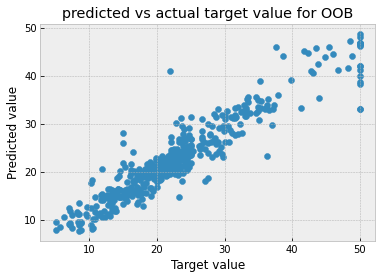

In [165]:
# plot OOB predictions for the tree the produced the lowest mse
plot_oob_actual_vs_target(y_oob, y_oob_pred)


If we look at the target variables distribution:

22.532806324110677 9.188011545278203 4.156783233554272 40.90882941466708


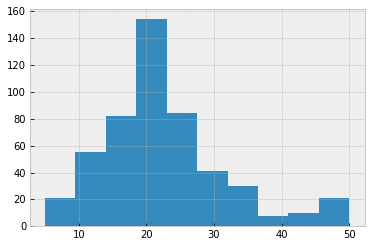

In [167]:
mean, std = y.mean(), y.std()
print(mean, std, mean - 2 * std, mean + 2 * std)
plt.hist(y);

We can see that most values are < 40 (95% are in the range (4 - 40)), which means we don't have a lot of observations with target value > 40, which might explain why our tree predictions are less accurate when we the target value > 40 

### Let's tune hyper-parameters using a train set, and test it using a test set (in addition to the OOB)

In [168]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

my_forest, y_oob_3, y_oob_pred_3 = find_lowest_mse_forest(x, y)
print('number of OOB prediction points:', len(y_oob_pred_3))

n_trees:10, sample size:300, min_leaf:1, max_features:13 --- oob mse: 11.9530798455874
n_trees:20, sample size:300, min_leaf:1, max_features:5 --- oob mse: 12.303073419022441
n_trees:20, sample size:300, min_leaf:1, max_features:13 --- oob mse: 11.639862347404737
n_trees:20, sample size:506, min_leaf:1, max_features:5 --- oob mse: 12.348716936497803
n_trees:20, sample size:506, min_leaf:1, max_features:8 --- oob mse: 12.659921359918393
n_trees:20, sample size:506, min_leaf:1, max_features:13 --- oob mse: 12.519781054214514
n_trees:50, sample size:300, min_leaf:1, max_features:5 --- oob mse: 11.490769724445222
n_trees:50, sample size:300, min_leaf:1, max_features:8 --- oob mse: 12.392724927789878
n_trees:50, sample size:300, min_leaf:1, max_features:13 --- oob mse: 12.165759926350171
n_trees:50, sample size:506, min_leaf:1, max_features:3 --- oob mse: 12.478786450134127
n_trees:50, sample size:506, min_leaf:1, max_features:5 --- oob mse: 11.735768033221198
n_trees:50, sample size:506, m

parameters that result in lowest forest oob: 100 trees, sample size 404, min_leaf 1, 8 max features
number of OOB prediction points: 506


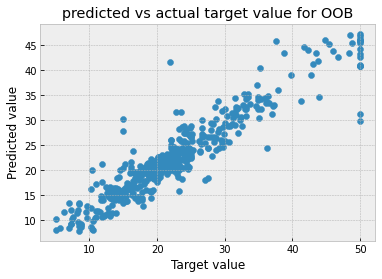

In [174]:

# plot OOB predictions for the tree the produced the lowest mse on the train set
plot_oob_actual_vs_target(y_oob_3, y_oob_pred_3)

### Test set

let's evalute this forest using the test set:

mean square error (Test) 3.1901748058609702


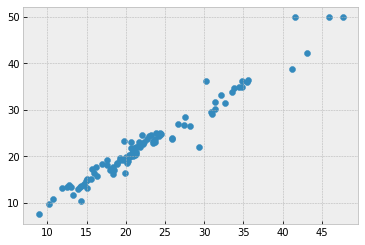

In [178]:
from sklearn.metrics import mean_squared_error

y_test_pred = my_forest.predict(x_test)
plt.scatter(y_test_pred, y_test)

print('mean square error (Test)', mean_squared_error(y_test_pred, y_test) )

### training set

mean square error (Train) 2.024174184280654


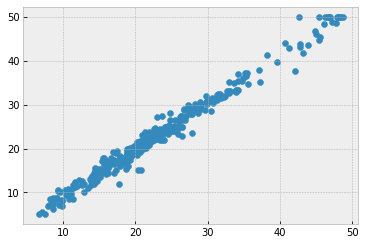

In [179]:
y_train_pred = my_forest.predict(x_train)
plt.scatter(y_train_pred, y_train)

print('mean square error (Train)', mean_squared_error(y_train_pred, y_train) )

We got pretty low MSE for both train and test set, see seems like our tree has good generalization

## Using Decision Tree and Random Forest for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
- Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.
  - You can use `sklearn.tree.DecisionTreeClassifier` and `sklearn.ensemble.RandomForestClassifier`
- Once you are satisfied with the model parameters, plot for each of the models (a single decision tree and random forest) the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from keras.datasets import mnist

plt.style.use('bmh')

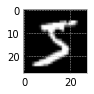

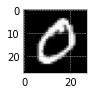

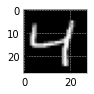

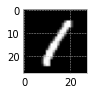

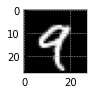

In [5]:
# let's run this on the full dataset:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# let's see a small sample of the data
for i in range(5):
    plt.subplot(3,4, i+1)
    plt.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
    plt.show()


x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

The dataset comes split into test and train data. 

#### default paramters model accuracy 

In [6]:
def evaluate_model(classifier, x_test, y_test, x_train, y_train, forest = False):
    y_test_pred = classifier.predict(x_test)
    y_train_pred = classifier.predict(x_train)
    acc_score = accuracy_score(y_train, y_train_pred)
    print(f'Model accuracy (Train) {acc_score:.3f}')
    acc_score = accuracy_score(y_test, y_test_pred)
    print(f'Model accuracy (Test) {acc_score:.3f}')

    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f'Model accuracy weighted f1 score: {f1:.3f}')

    if forest:
        print('Forest OOB score = ',classifier.oob_score)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    print('confusion matrix:')
    print(conf_matrix)
    
    print('\nclassification report:')
    print(classification_report(y_test, y_test_pred, target_names = ['0','1','2','3','4','5','6','7','8','9']))
    
    return conf_matrix

In [7]:
# Let's check the accuracy of the model with the default parameters

tree_classifier_basic = DecisionTreeClassifier(random_state=2)
tree_classifier_basic = tree_classifier_basic.fit(x_train, y_train)

evaluate_model(tree_classifier_basic, x_test, y_test, x_train, y_train);


Model accuracy (Train) 1.000
Model accuracy (Test) 0.878
Model accuracy weighted f1 score: 0.878
confusion matrix:
[[ 909    1   11   10    6   15   12    5    9    2]
 [   0 1091   10    2    1    5   10    6    8    2]
 [  12    8  884   42   16    7    9   21   24    9]
 [   6    4   34  860    8   39    5    8   21   25]
 [   6    4    7    4  861    8   13    9   24   46]
 [  13    7    6   37    6  749   22    5   31   16]
 [  21    5   14   11   11   20  848    0   22    6]
 [   2   15   22   14    7    4    2  928   13   21]
 [  10    6   21   39   24   28   15    8  794   29]
 [  15    4    8   20   45   11    4   21   24  857]]

classification report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.95      0.96      0.96      1135
           2       0.87      0.86      0.86      1032
           3       0.83      0.85      0.84      1010
           4       0.87      0.88      0.88       982
     

#### Test accuracy is 0.878 vs. 1.0 training data, which implies the model doesn't generalize well and might an overfit to the training data.

### Let's Tune Hyper Parameters

#### Optimizin Max Depth

let's try to optimize max depth by training the tree with multiple depths and checking the cross validation error.

In [21]:
KFOLD_SPLITS = 3

In [22]:
def plot_errors (x_axis, train_error_mean_list, valid_error_mean_list, x_label):
    
    fig=plt.figure(figsize=(15,6))
    plt.xlabel(x_label)
    plt.xticks(x_axis)
    plt.ylabel('error rate')
    plt.plot(x_axis, train_error_mean_list, label="train error", marker = 'o')
    plt.plot(x_axis, valid_error_mean_list, label="validation error", marker = 'o')

    plt.legend()
    plt.show()

.............................................

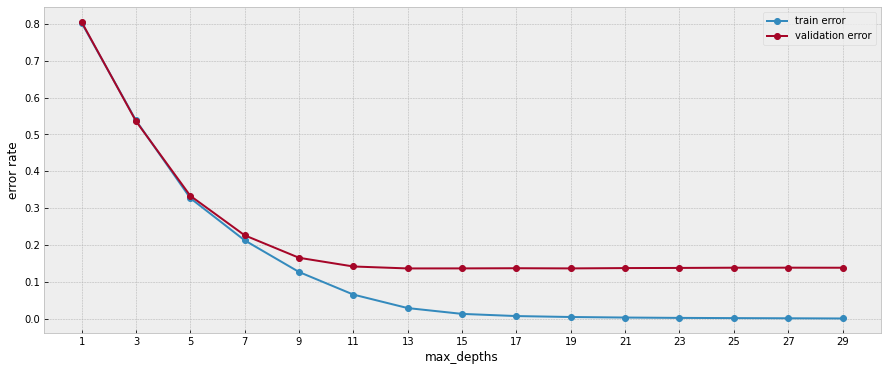

In [25]:

train_error_mean_list = []
valid_error_mean_list = []

max_depths = np.arange(1, 30, 2)

for depth in max_depths:
 
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    train_error_list = []
    valid_error_list = []

    for train_idx, test_idx in kf.split(x_train, y_train):

        print('.', end = '')
        
        tree_classifier = DecisionTreeClassifier(max_depth=depth, random_state=2)
        tree_classifier = tree_classifier.fit(x_train[train_idx], y_train[train_idx])
        
        y_test_pred = tree_classifier.predict(x_train[test_idx])
        y_train_pred = tree_classifier.predict(x_train[train_idx])

        train_error_list.append(1 - accuracy_score(y_train[train_idx],y_train_pred))
        valid_error_list.append(1 - accuracy_score(y_train[test_idx],y_test_pred))

    train_error_mean_list.append(np.array(train_error_list).mean())
    valid_error_mean_list.append(np.array(valid_error_list).mean())

plot_errors(max_depths, train_error_mean_list, valid_error_mean_list, 'max_depths')


Notes: the larger the depth of the tree - the more complex the model and the more it tends to overfitting. Very low depth will cause an underftit 

Seems like the validation error doesn't improve much past depth of 11.

#### Optimizing min_samples_split

..........................................

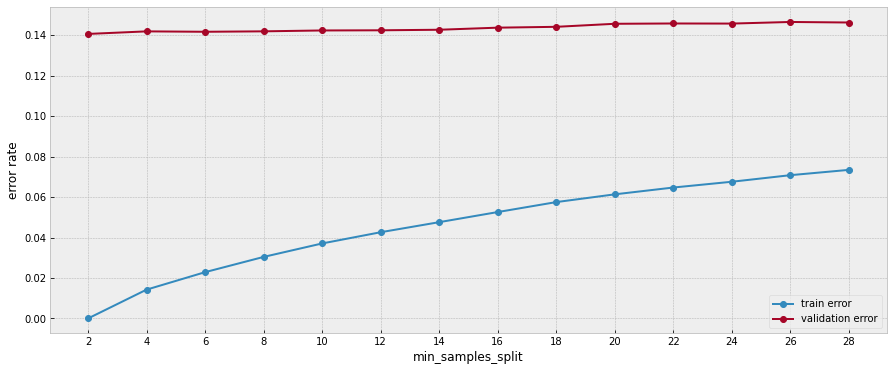

In [26]:
train_error_mean_list = []
valid_error_mean_list = []

min_samples_split = np.arange(2, 30, 2)

for min_sample_splt in min_samples_split:
 
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    train_error_list = []
    valid_error_list = []

    for train_idx, test_idx in kf.split(x_train, y_train):

        print('.', end = '')

        tree_classifier = DecisionTreeClassifier(random_state=2, min_samples_split=int(min_sample_splt))
        tree_classifier = tree_classifier.fit(x_train[train_idx], y_train[train_idx])
        
        y_test_pred = tree_classifier.predict(x_train[test_idx])
        y_train_pred = tree_classifier.predict(x_train[train_idx])

        train_error_list.append(1 - accuracy_score(y_train[train_idx],y_train_pred))
        valid_error_list.append(1 - accuracy_score(y_train[test_idx],y_test_pred))

    train_error_mean_list.append(np.array(train_error_list).mean())
    valid_error_mean_list.append(np.array(valid_error_list).mean())


plot_errors (min_samples_split, train_error_mean_list, valid_error_mean_list, 'min_samples_split')


Seems like the minimum of min_samples_split = 2 or 6 produces the minimal validation error. Since the default parameters are overfitting, let's pick 6.

Higher values of min_samples_split help reduce overfitting but may cause underfitting.


#### Optimizing max features

.........training: [0.0, 0.0, 0.0]
validation [0.17718333333333333, 0.17718333333333333, 0.21585000000000001]


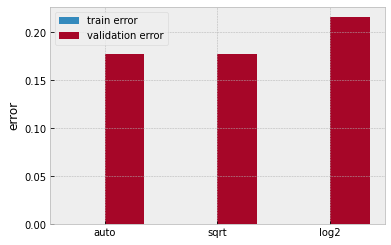

In [285]:
train_error_mean_list = []
valid_error_mean_list = []

max_features = ['auto', 'sqrt', 'log2']
for max_feat in max_features:
 
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    train_error_list = []
    valid_error_list = []

    for train_idx, test_idx in kf.split(x_train, y_train):
        
        print('.', end = '')

        tree_classifier = DecisionTreeClassifier(random_state=2, max_features=max_feat)
        tree_classifier = tree_classifier.fit(x_train[train_idx], y_train[train_idx])
        
        y_test_pred = tree_classifier.predict(x_train[test_idx])
        y_train_pred = tree_classifier.predict(x_train[train_idx])

        train_error_list.append(1 - accuracy_score(y_train[train_idx],y_train_pred))
        valid_error_list.append(1 - accuracy_score(y_train[test_idx],y_test_pred))

    train_error_mean_list.append(np.array(train_error_list).mean())
    valid_error_mean_list.append(np.array(valid_error_list).mean())


ind = np.arange(len(max_features))  
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, train_error_mean_list, width, label='train error')
rects2 = ax.bar(ind + width/2, valid_error_mean_list, width, label='validation error')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('error')
ax.set_xticks(ind)
ax.set_xticklabels(max_features)
ax.legend()

print('training:',train_error_mean_list)
print('validation', valid_error_mean_list)

Auto / sqrt seem to work slightly better than log2. Let's examine more values.

....................................

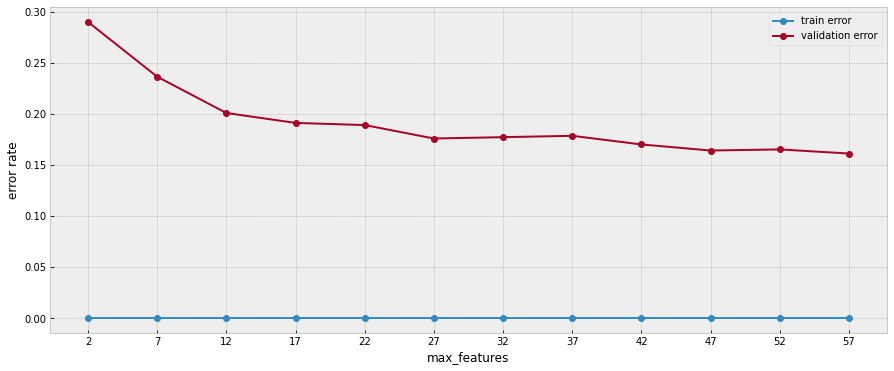

In [31]:
train_error_mean_list = []
valid_error_mean_list = []

max_features = np.arange(2, 60 ,5)

for max_feat in max_features:
 
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    train_error_list = []
    valid_error_list = []

    for train_idx, test_idx in kf.split(x_train, y_train):

        print('.', end = '')

        tree_classifier = DecisionTreeClassifier(random_state=2, max_features=int(max_feat))
        tree_classifier = tree_classifier.fit(x_train[train_idx], y_train[train_idx])
        
        y_test_pred = tree_classifier.predict(x_train[test_idx])
        y_train_pred = tree_classifier.predict(x_train[train_idx])

        train_error_list.append(1 - accuracy_score(y_train[train_idx],y_train_pred))
        valid_error_list.append(1 - accuracy_score(y_train[test_idx],y_test_pred))

    train_error_mean_list.append(np.array(train_error_list).mean())
    valid_error_mean_list.append(np.array(valid_error_list).mean())

plot_errors (max_features, train_error_mean_list, valid_error_mean_list, 'max_features')



max features - smaller values speed up the process of building the tree, and also can help with overfitting

validation error keeps decreasing as max feaures increases, but not too significantly past 47.

### Let's run our model with all the hyper-paramters and check the generalization error:

In [24]:
tree_classifier_optimized = DecisionTreeClassifier(max_depth=15, random_state=2, max_features=47, min_samples_split = 6)
tree_classifier_optimized = tree_classifier_optimized.fit(x_train, y_train)

evaluate_model(tree_classifier_optimized, x_test, y_test, x_train, y_train);

Model accuracy (Train) 0.954
Model accuracy (Test) 0.863
Model accuracy weighted f1 score: 0.862
confusion matrix:
[[ 909    1    7    5    3   11   15    6   13   10]
 [   0 1088    1    9    4    4    5    5   17    2]
 [  22    4  879   32   22    8    8   27   24    6]
 [   8    5   20  847   13   40    6   18   40   13]
 [   5    9   13   11  823   13   15   17   16   60]
 [  14    9   17   45   12  736   17    7   22   13]
 [  19    6   25    4   23   17  838    0   22    4]
 [   1   11   26   11   11    5    1  925   10   27]
 [  12   12   29   44   22   34   30   16  733   42]
 [   7   11   11   13   46   22    4   17   30  848]]

classification report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.94      0.96      0.95      1135
           2       0.86      0.85      0.85      1032
           3       0.83      0.84      0.83      1010
           4       0.84      0.84      0.84       982
     

this didn't improve the accuracy on the test set (it's now 0.863), bet the model seems more balanced: Model accuracy is still high (0.863) and training error is lower (0.954) and the different is more reasonable.

Let's try gridsearch

In [30]:
from sklearn.model_selection import GridSearchCV

max_features = np.arange(2, 150 ,5)
min_samples_split = np.arange(2, 30, 2)
max_depth = np.arange(1, 30, 2)

hyper_params = dict(max_features = max_features, max_depth = max_depth, min_samples_split = min_samples_split)

grid = GridSearchCV(tree_classifier_basic, hyper_params, cv = 3, return_train_score = True, n_jobs = -1)
best_parameters = grid.fit(x_train, y_train)

print(best_parameters.best_params_)

{'max_depth': 15, 'max_features': 132, 'min_samples_split': 8}


Note: we probably should have limited the max_features to a lower number, but we didn't have time to run gridsearch again so we used the selected max_features of 132 in our optimized model.

### let's run the model with our selected paramters

In [10]:
tree_classifier_optimized = DecisionTreeClassifier(max_depth=15, random_state=2, max_features=132, min_samples_split = 8)
tree_classifier_optimized = tree_classifier_optimized.fit(x_train, y_train)

conf_matrix = evaluate_model(tree_classifier_optimized, x_test, y_test, x_train, y_train);

Model accuracy (Train) 0.956
Model accuracy (Test) 0.869
Model accuracy weighted f1 score: 0.868
confusion matrix:
[[ 900    2   16   10    8   19    9    3    9    4]
 [   0 1098    8    6    2    4    1    3   13    0]
 [  22   15  883   25   10    9    7   26   27    8]
 [   6    8   26  852    1   40    9   16   34   18]
 [  11    5   12   11  849    8   11   12   16   47]
 [  14   10   15   45   14  730   19   10   17   18]
 [  21    9   11    7   16   22  857    2    9    4]
 [   1   15   23   14    7    9    4  925    7   23]
 [  15   18   40   40   29   33   15   16  737   31]
 [   8    4   14   15   47   19    6   20   22  854]]

classification report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       980
           1       0.93      0.97      0.95      1135
           2       0.84      0.86      0.85      1032
           3       0.83      0.84      0.84      1010
           4       0.86      0.86      0.86       982
     

### Results of model accuracy and measurements:

This model is pretty similar to our manually tuned one:
this didn't improve the accuracy on the test set (it's now 0.869), but the model also seems more balanced than the original one: Model accuracy is still high (0.869) and training error is lower (0.956) and the different between them is more reasonable.

The classification report gives a good overview of precision, recall and f1-score for each class/digit, we will look into more metrics later.

Notes about different digits:
    
 -  The higheset precision (correctly classified) digits are 1, 0, 6 and 7
 -  The highest recall (true positives out of all relevant elements, how complete the results are ) are for digits: 1, 0  and 6, 7 which means the classifier is predicting correctly most of them (high percentage of all elements are true positives, meaning - correct classifications.)

### let's estimate the class assignment probabilities for all the correctly classified and misclassified examples 

In [28]:
def get_metrics_from_confusion_matrix(confusion_matrix):
    
    diagonal = np.diag(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - diagonal   # False Positive
    fn = confusion_matrix.sum(axis=1) - diagonal   # False Negative
    tp = diagonal                                  # True Positive
    tn = confusion_matrix.sum() - (fp + fn + tp)   # True Negative
    
    return fp, fn, tp, tn

In [27]:
def print_digits_probabilities(conf_matrix):
    
    fp, fn, tp, tn = get_metrics_from_confusion_matrix(conf_matrix)

    percision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (percision * recall) / (percision + recall)
          
    # plot precision, recall, and f1 score
    plt.figure(figsize=(10, 8))
    digits = np.arange(10)
    plt.bar(digits + 0.00, percision, color = 'b', width = 0.25, label = 'percision')
    plt.bar(digits + 0.25, recall, color = 'y', width = 0.25,  label = 'recall')
    plt.bar(digits + 0.50, f1, color = 'g', width = 0.25,  label = 'f1 score')
    plt.xticks(digits)
    plt.xlabel('digits')
    plt.title('percision, recall and f1 score per digit')
    plt.show()
    
    false_positive_rate = fp/(fp+tn)
    false_negative_rate = fn/(tp+fn)

    # Go over digits and print their scores (with explanations)
    for digit in digits:
        print(f'\nDigit {digit}')
        print(f"Precision: from all digits classified as {digit}, {percision[digit]:.2f} were actually {digit}'s")
        print(f"Recall (sensativity): from all '{digit}' digits in the set , {recall[digit]:.2f} were predicted correctly")
        print(f'misclassification rates for {digit} :')
        print(f' - other digits classified as {digit} is {false_positive_rate[digit]:.3f}')        
        print(f' - miss rate - {digit} that was classified as something else is {false_negative_rate[digit]:.3f}')
        print(f"f1 score: digit {digit} has an f1 score of {f1[digit]:.2f} ")

        
    # plot false positive and false negative rates
    plt.figure(figsize=(10, 8))
    digits = np.arange(10)
    plt.bar(digits + 0.00, false_positive_rate, color = 'b', width = 0.25, label = 'False positive rate')
    plt.bar(digits + 0.25, false_negative_rate, color = 'r', width = 0.25,  label = 'False negative rate')
    plt.xticks(digits)
    plt.legend()
    plt.xlabel('digits')
    plt.title('False positive and False negative rate')
    plt.show()

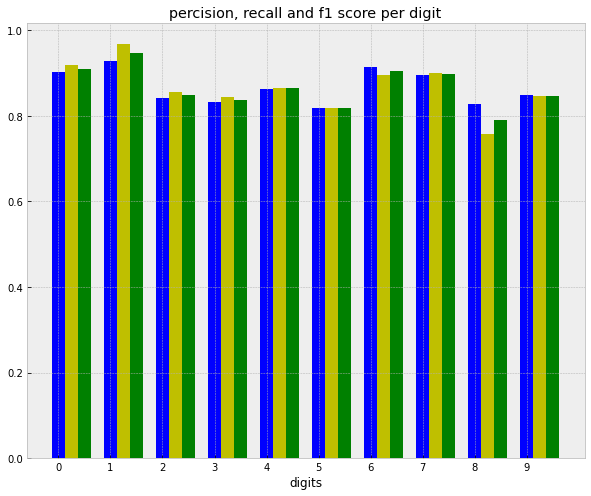


Digit 0
Precision: from all digits classified as 0, 0.90 were actually 0's
Recall (sensativity): from all '0' digits in the set , 0.92 were predicted correctly
misclassification rates for 0 :
 - other digits classified as 0 is 0.011
 - miss rate - 0 that was classified as something else is 0.082
f1 score: digit 0 has an f1 score of 0.91 

Digit 1
Precision: from all digits classified as 1, 0.93 were actually 1's
Recall (sensativity): from all '1' digits in the set , 0.97 were predicted correctly
misclassification rates for 1 :
 - other digits classified as 1 is 0.010
 - miss rate - 1 that was classified as something else is 0.033
f1 score: digit 1 has an f1 score of 0.95 

Digit 2
Precision: from all digits classified as 2, 0.84 were actually 2's
Recall (sensativity): from all '2' digits in the set , 0.86 were predicted correctly
misclassification rates for 2 :
 - other digits classified as 2 is 0.018
 - miss rate - 2 that was classified as something else is 0.144
f1 score: digit 2 ha

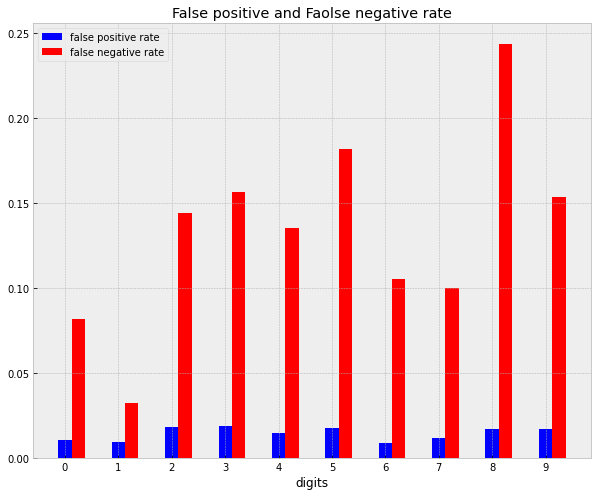

In [15]:
print_digits_probabilities(conf_matrix)

### Let's plot the confusion matrix

In [29]:
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          normalize=True):

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

This classifier performs best for digits: 1, 0, 6, 7 (over 0.9 f1 score) and slightly less well for 8 (0.89)
and worse for 4 (0.86), 9,2 (0.85), 3 (0.84) and 5 (0.82)
    

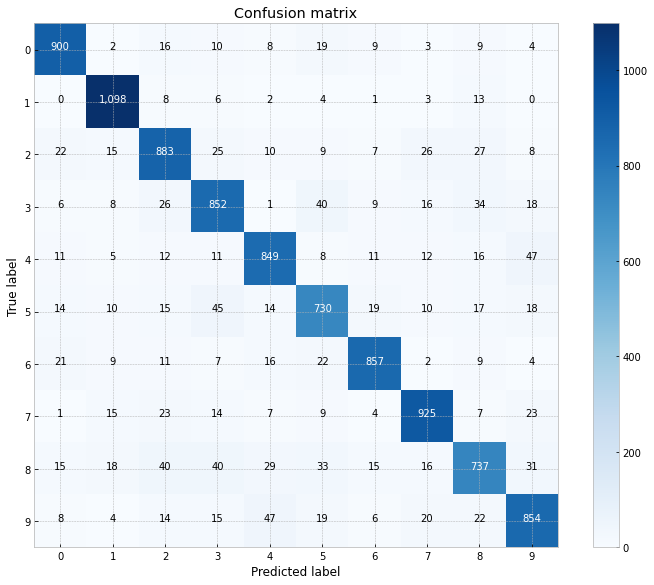

In [30]:
plot_confusion_matrix(conf_matrix,['0','1','2','3','4', '5', '6', '7', '8', '9'], False);

#### Classifier errors

Ignoring the total number of digits in the dataset, 
let's look at the confusion matrix for common errors. 

We can see that the most common erros the model does are (number of errors is in ()):
    
 - 0 is missclassifed as 5 or 2 (16, 19)
 - 1 is missclassified as 8 (13)
 - 2 is missclassified as 7 or 8 (26, 27)
 - 3 is missclassified as 5 or 8 (40, 34)
 - 4 is missclassified as 9 (47)
 - 5 is missclassified as 3 (45)
 - 6 is missclassified as 0 or 5 (21, 22)
 - 7 is missclassified as 2 or 9 (23, 23)
 - 8 is missclassified as 2 or 3 (40, 40)
 - 9 is missclassified as 4 (47)
 

In [31]:
def digit_misclassified(digit, row):
    row_in_matrix = row.copy()
    total_appearances_of_digit = np.sum(row_in_matrix)
    #print('total_appearances_of_digit = ', total_appearances_of_digit)
    row_in_matrix[digit] = 0 
    total_errors = np.sum(row_in_matrix)
    percent_errors = np.round(total_errors/ total_appearances_of_digit, 2) * 100
    
    print(f'\ntotal errors for digit {digit} (it was classified as something else) = {total_errors} ({percent_errors:.1f}%)')
    most_confused_with = np.argmax(row_in_matrix)
    times_confused_with = row_in_matrix[most_confused_with]
    percent_from_all_these_errors = times_confused_with / total_errors * 100
    print(f'most common misclassification is: {most_confused_with}  - {times_confused_with} times ({percent_from_all_these_errors:.2f}%)')
           
        
for digit in np.arange(10):
    digit_misclassified(digit, conf_matrix[digit])


total errors for digit 0 (it was classified as something else) = 80 (8.0%)
most common misclassification is: 5  - 19 times (23.75%)

total errors for digit 1 (it was classified as something else) = 37 (3.0%)
most common misclassification is: 8  - 13 times (35.14%)

total errors for digit 2 (it was classified as something else) = 149 (14.0%)
most common misclassification is: 8  - 27 times (18.12%)

total errors for digit 3 (it was classified as something else) = 158 (16.0%)
most common misclassification is: 5  - 40 times (25.32%)

total errors for digit 4 (it was classified as something else) = 133 (14.0%)
most common misclassification is: 9  - 47 times (35.34%)

total errors for digit 5 (it was classified as something else) = 162 (18.0%)
most common misclassification is: 3  - 45 times (27.78%)

total errors for digit 6 (it was classified as something else) = 101 (11.0%)
most common misclassification is: 5  - 22 times (21.78%)

total errors for digit 7 (it was classified as something e

Seems like the classifier's most common errors are separating:
- 4 and 9 (47 + 47 times)
- 3 and 5 (40 + 45 times)
- 2 and 8 (27 + 40 times)


### Features importance:
After being fit, the model provides a feature_importances_ property that provides the relative importance scores for each input feature.

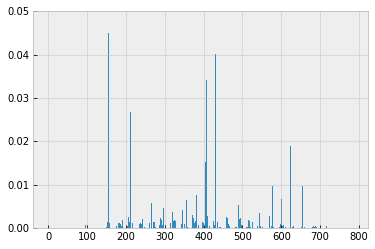

In [44]:
features_importance = tree_classifier_optimized.feature_importances_

for idx, score in enumerate(features_importance):
    #let's translate these to pixles:
    p_x = int(np.floor(idx / 28))
    p_y = int(np.mod(idx, 28))
    #print(f'Feature: {idx}, point ({p_x}, {p_y}) Score: {score:.3f}')

    
# plot feature importance
plt.bar([feature for feature in range(len(features_importance))], features_importance)
plt.show()

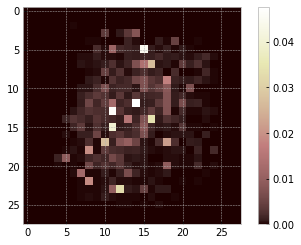

In [45]:
# plot pixel importance

image_fi = np.reshape(features_importance, (28,28))

plt.imshow(image_fi, cmap='pink')
plt.colorbar()
plt.show()

This makes sense - the most important pixels are in the center of the image plus the center diagonals, which is where most digits span to. The points at the outer edges of the image have very low significance score.

## Random Forest Tuning

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
forest_classifier_basic = RandomForestClassifier(random_state=2, oob_score=True)
forest_classifier_basic = forest_classifier_basic.fit(x_train, y_train)

evaluate_model(forest_classifier_basic, x_test, y_test, x_train, y_train, forest = True);

Model accuracy (Train) 1.000
Model accuracy (Test) 0.970
Model accuracy weighted f1 score: 0.970
Forest OOB score =  True
confusion matrix:
[[ 968    0    1    0    0    2    4    1    4    0]
 [   0 1124    2    3    0    2    2    1    1    0]
 [   6    0  998    6    2    0    3    9    8    0]
 [   0    0   11  975    0    6    0    9    6    3]
 [   1    0    1    0  955    0    5    0    2   18]
 [   3    1    1   15    3  857    4    1    4    3]
 [   6    3    1    0    4    5  936    0    3    0]
 [   1    3   19    1    1    0    0  992    4    7]
 [   4    0    4    6    2    6    4    3  936    9]
 [   5    6    2   12   14    3    1    3    6  957]]

classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97 

Model accuracy is pretty high. Let's run gridsearch and see if we can improve it.

In [37]:
from sklearn.model_selection import GridSearchCV

dataset_size = x_train.shape[0]
max_samples = []
for i in range(2,5):
    max_samples.append(int(np.floor(dataset_size / i)))
    
n_estimators = [100, 500, 1000]
max_depth = [ 15, 25]
min_samples_split = [10, 20, 50]


hyper_params = dict(n_estimators = n_estimators, max_depth = max_depth, max_samples = max_samples ,
              min_samples_split = min_samples_split)

grid = GridSearchCV(forest_classifier_basic, hyper_params, cv = 3, return_train_score = True, n_jobs = -1)
best_parameters = grid.fit(x_train, y_train)

print(best_parameters.best_params_)

/Users/noa/Documents/Y-Data/Fall 2/Supervised learning/venv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'max_depth': 25, 'max_samples': 30000, 'min_samples_split': 10, 'n_estimators': 500}


Note: we forgot to put max_features here, but didn't have time to run gridsearch again so we will go ahead and tune max features manually:

### Let's tune max features manually

......

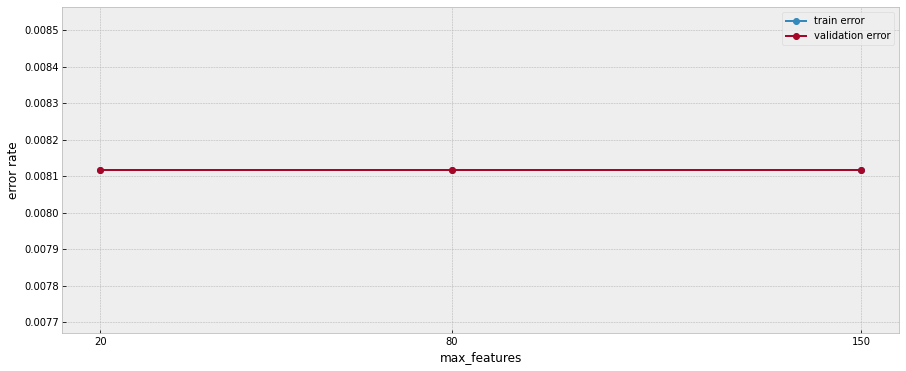

In [30]:
KFOLD_SPLITS = 2

train_error_mean_list = []
valid_error_mean_list = []

max_features = [20, 80, 150]

for max_feat in max_features:
 
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    train_error_list = []
    valid_error_list = []

    for train_idx, test_idx in kf.split(x_train, y_train):

        print('.', end = '')

        forest_classifier = RandomForestClassifier(random_state=2, max_features=int(max_feat), n_jobs = -1)
        forest_classifier = forest_classifier_optimized.fit(x_train, y_train)
        
        y_test_pred = forest_classifier.predict(x_train[test_idx])
        y_train_pred = forest_classifier.predict(x_train[train_idx])

        train_error_list.append(1 - accuracy_score(y_train[train_idx],y_train_pred))
        valid_error_list.append(1 - accuracy_score(y_train[test_idx],y_test_pred))

    train_error_mean_list.append(np.array(train_error_list).mean())
    valid_error_mean_list.append(np.array(valid_error_list).mean())

plot_errors (max_features, train_error_mean_list, valid_error_mean_list, 'max_features')


as we don't see an impact on the error, we'll keep sklearn's max features default (sqrt(n), which is 28 in our case.

### let's run the model with the chosen paramters

In [31]:
forest_classifier_optimized = RandomForestClassifier(random_state=2, max_depth= 25, max_samples = 30000, min_samples_split = 10, n_estimators = 500,  oob_score=True)
forest_classifier_optimized = forest_classifier_optimized.fit(x_train, y_train)

conf_matrix_forest = evaluate_model(forest_classifier_optimized, x_test, y_test, x_train, y_train, forest = True);

Model accuracy (Train) 0.992
Model accuracy (Test) 0.966
Model accuracy weighted f1 score: 0.965
Forest OOB score =  True
confusion matrix:
[[ 968    0    0    0    0    2    5    1    4    0]
 [   0 1119    3    3    1    1    4    0    3    1]
 [   6    0  995    9    3    0    4    8    7    0]
 [   1    0   12  969    0    7    0    9    8    4]
 [   1    0    2    0  950    0    5    0    2   22]
 [   5    1    0   13    3  853    6    3    5    3]
 [   6    3    1    0    4    4  936    0    4    0]
 [   1    5   21    2    1    0    0  981    5   12]
 [   5    0    6    7    5    4    5    4  928   10]
 [   7    5    3   12   11    2    1    5    7  956]]

classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.96      0.96      1032
           3       0.95      0.96      0.96      1010
           4       0.97      0.97 

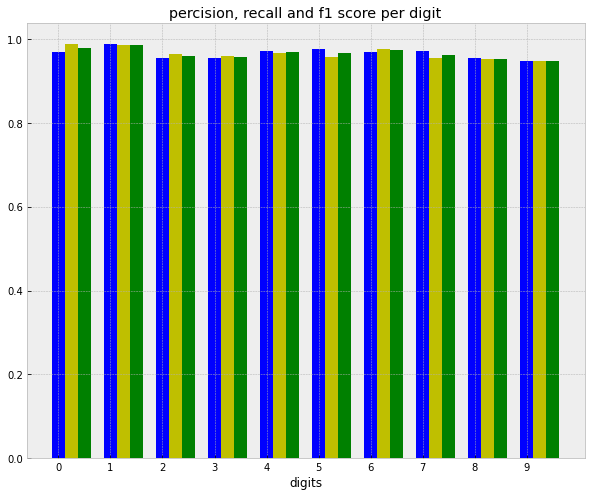


Digit 0
Precision: from all digits classified as 0, 0.97 were actually 0's
Recall (sensativity): from all '0' digits in the set , 0.99 were predicted correctly
misclassification rates for 0 :
 - other digits classified as 0 is 0.004
 - miss rate - 0 that was classified as something else is 0.012
f1 score: digit 0 has an f1 score of 0.98 

Digit 1
Precision: from all digits classified as 1, 0.99 were actually 1's
Recall (sensativity): from all '1' digits in the set , 0.99 were predicted correctly
misclassification rates for 1 :
 - other digits classified as 1 is 0.002
 - miss rate - 1 that was classified as something else is 0.014
f1 score: digit 1 has an f1 score of 0.99 

Digit 2
Precision: from all digits classified as 2, 0.95 were actually 2's
Recall (sensativity): from all '2' digits in the set , 0.96 were predicted correctly
misclassification rates for 2 :
 - other digits classified as 2 is 0.005
 - miss rate - 2 that was classified as something else is 0.036
f1 score: digit 2 ha

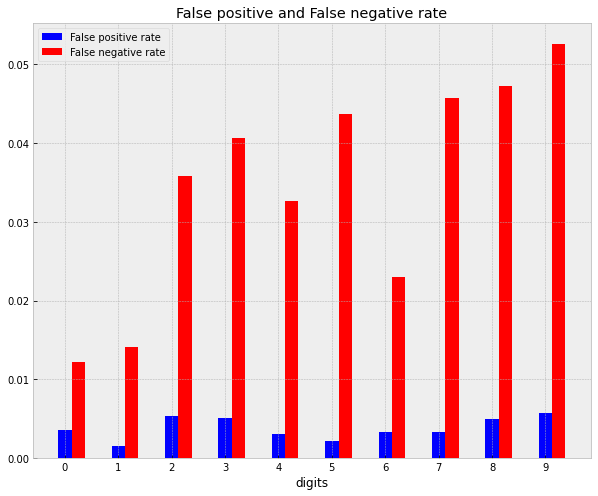

In [32]:
print_digits_probabilities(conf_matrix_forest)

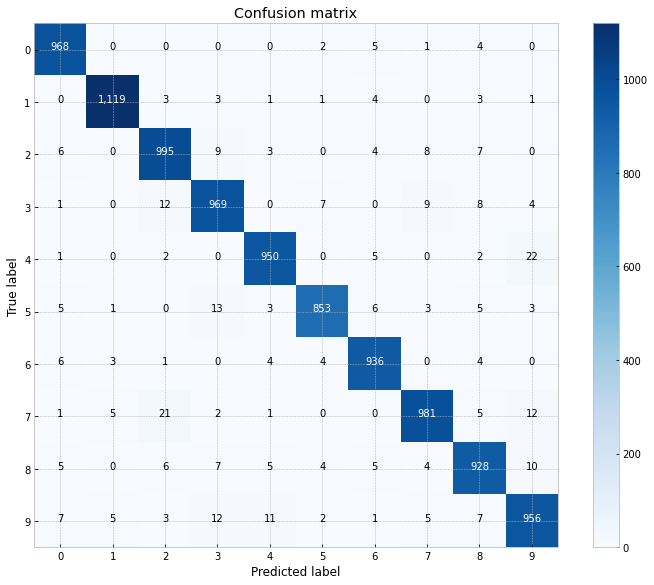

In [119]:
plot_confusion_matrix(conf_matrix_forest,['0','1','2','3','4', '5', '6', '7', '8', '9'], False);

We can see the forest has a much higher accuracy rate then the single tree  (all digits' percision and recall are over 95%)

#### Classifier errors

In [173]:
for digit in np.arange(10):
    digit_misclassified(digit, conf_matrix_forest[digit])


total errors for digit 0 (it was classified as something else) = 12 (1.0%)
most common misclassification is: 6  - 5 times (41.67%)

total errors for digit 1 (it was classified as something else) = 16 (1.0%)
most common misclassification is: 6  - 4 times (25.00%)

total errors for digit 2 (it was classified as something else) = 37 (4.0%)
most common misclassification is: 3  - 9 times (24.32%)

total errors for digit 3 (it was classified as something else) = 41 (4.0%)
most common misclassification is: 2  - 12 times (29.27%)

total errors for digit 4 (it was classified as something else) = 32 (3.0%)
most common misclassification is: 9  - 22 times (68.75%)

total errors for digit 5 (it was classified as something else) = 39 (4.0%)
most common misclassification is: 3  - 13 times (33.33%)

total errors for digit 6 (it was classified as something else) = 22 (2.0%)
most common misclassification is: 0  - 6 times (27.27%)

total errors for digit 7 (it was classified as something else) = 47 (5.0

This classifier has very high acuracy, and the number of errors is very low.

Seems like the classifier's most common errors (which are almost negligible) are:
- classifying 4 as 9 (22 times)
- classifying 7 as 2 (21 times)

7,8,9 seem to have more misclassifications then other digits. (both in numbers and percentage)

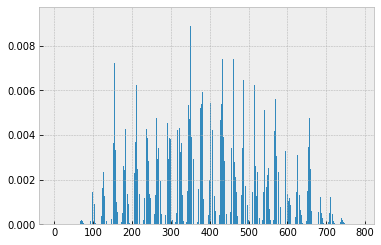

In [42]:
features_importance = forest_classifier_optimized.feature_importances_

for idx, score in enumerate(features_importance):
    #let's translate these to pixles:
    p_x = int(np.floor(idx / 28))
    p_y = int(np.mod(idx, 28))
    #print(f'Feature: {idx}, point ({p_x}, {p_y}) Score: {score:.3f}')

    
# plot feature importance
plt.bar([feature for feature in range(len(features_importance))], features_importance)
plt.show()

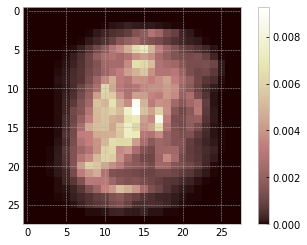

In [43]:
# plot pixel importance

image_fi = np.reshape(features_importance, (28,28))

plt.imshow(image_fi, cmap='pink')
plt.colorbar()
plt.show()

Similar to the previous plot - the most important pixels are in the center of the image which is where most digits span to. The points at the outer edges of the image have very low significance score.

## References
- https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/